In [1]:
#importar librerias
import numpy as np
import cobra
#definir modelo extraido desde archivos anexados en el paper de Shen.
model=cobra.io.load_matlab_model("supplementary_software_code.mat", variable_name="acetylation_model")
print(model.objective)

import scipy.io
mat = scipy.io.loadmat('supplementary_software_code.mat')

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Maximize
1.0*biomass_objective - 1.0*biomass_objective_reverse_04afc


In [2]:

epsilon = 0.01
extended_objective = model.problem.Objective(
    model.reactions.biomass_objective.flux_expression + 
    epsilon * model.reactions.EX_KAC.flux_expression,
    direction='max')
model.objective = extended_objective
solution = model.optimize()

In [4]:
cellularlines= mat["acetlevellist"] #acetlevellist contiene los nombres de las lineas celulares
celllinenames= mat["celllinenames_ccle1"] #celllinenames_ccle1 contains CCLE cell line names
cclemetz= mat["ccle_expression_metz"] #ccle_expression_metz matriz gene expression data (3084, 1037)  
ccleidsmet= mat["ccleids_met"] #ccleids_met id de genes
acetlevel=mat["acetlevellistval"] #acetlevellistval lista de valores de acetilacion


In [5]:
#Lineas celulares, Nombre e indice 

list_cell=cellularlines
dicc_cell={}
for i,name in enumerate(celllinenames):  # nombres provenientes de "celllinenames_ccle1" (1037, 1)
    for j,name2 in enumerate(cellularlines): #nombres provenientes de "acetlevellist" (14,1)
        if name2==name:
            dicc_cell[name2[0][0]]=i        #[0,0] -> array    
print(dicc_cell) #dicc_cell -> iii

   


{'HL60': 48, 'HCT116': 54, 'A549': 60, 'MDAMB231': 67, 'PC3': 132, 'U251MG': 194, 'U2OS': 287, 'SAOS2': 296, 'HUH7': 354, 'SW480': 442, 'PANC1': 479, 'MCF7': 553, 'U937': 554, 'NB4': 627}


In [6]:

cclemetz= mat["ccle_expression_metz"] #ccle_expression_metz matriz gene expression data (3084, 1037)  
ccleidsmet= mat["ccleids_met"] #ccleids_met id de genes

geneson={}    
genesoff={}

for linea_celular,indice in dicc_cell.items(): 
    posicion=0 #inicializando posicion
    lista_genes= cclemetz[:,indice] # 3084 X1 
    geneson[linea_celular]=[]    
    genesoff[linea_celular]=[]
    
    for posicion,valor in enumerate(lista_genes):  #recorro los  valores de la lista 3084 datos (columna->indice)
        #print(posicion)    
        
        if valor > 2 and ccleidsmet[posicion][0][0] not in geneson  : #not in lista_name_geneson para evitar repeticiones de genes
    
            geneson[linea_celular].append(ccleidsmet[posicion][0][0]) #append para agregar elementos a la lista vacia
            
            
        if valor < -2 and ccleidsmet[posicion][0][0] not in genesoff:
            genesoff[linea_celular].append(ccleidsmet[posicion][0][0])
    
     
print('Genes on : ',geneson[linea_celular])    
print('______________________________________________________________________________________________________________________________')  
print('Genes off : ',genesoff[linea_celular])  

Genes on :  ['CYP2E1', 'IDI2', 'UROC1', 'INPP5A', 'ATP6V0A2', 'ST3GAL3', 'IREB2', 'ACSL4', 'ACSL4', 'PIKFYVE', 'ATP5J2', 'PGK1', 'NDUFB6', 'CHPT1', 'QDPR', 'CAD', 'DTYMK', 'INPP5D', 'HADHB', 'DNMT1', 'NDUFA7', 'ANPEP', 'INPP5D', 'INPP5D', 'LPL', 'LPL', 'MPO', 'MPO', 'SLC43A1', 'SLC2A5', 'SLC2A5', 'SLC22A4', 'PIK3CG', 'PIK3CG', 'HAL', 'HDC', 'AHCYL1', 'DGKZ', 'TBXAS1', 'HADHA', 'HADHA', 'PPAT', 'PRDX3', 'SPHK2', 'CYP2E1', 'CYP2E1', 'CPT1A', 'AK2', 'PIKFYVE', 'ST3GAL6', 'PAICS', 'IREB2', 'CAT', 'ABCA1', 'SPTLC2', 'SHMT1', 'PNLIPRP2', 'ATP6V0A2', 'SETD8', 'CHST4', 'SLC28A3', 'DNMT3B', 'CHAT', 'PGM2', 'SETD8', 'SETD8', 'PGM2', 'PGM2', 'CHST11', 'ETNK1', 'NDUFA10', 'SLC20A1', 'MGAT4A', 'GBGT1', 'PIGL', 'INPP5D', 'HIBADH', 'ATP6V0A2', 'TGDS', 'ACAD10', 'CHST13', 'ENTPD1', 'SPCS2', 'SPHK2']
______________________________________________________________________________________________________________________________
Genes off :  ['GAMT', 'HEXB', 'EXT1', 'BLVRB', 'IDS', 'AK1', 'P4HA2', 'AGL', '

In [7]:
#Usar la lista de los genes apagados para crear redes metabólicas específicas para cada línea celular:

mediums=mat["acetlevlistmedia"] #acetlevlistmedia contiene los nombres de los medios de cultivo
#Obtencion de un modelo por cada linea celular
nombre_lineacelular=[]
valores_lineacelular=[]
for index,linea_celular in enumerate(cellularlines):
    linea_celular=linea_celular[0][0]
    nombre_lineacelular.append(linea_celular)
    modeli=model.copy() #Realizamos una copia para no acumular knockout de las lineas celulares anteriores
    

    #Esto elimina todos los genes que estan apagados en la linea celular
    for gene in genesoff[linea_celular]:
        if gene in modeli.genes:
            modeli.genes.get_by_id(gene).knock_out()
    
    #Aqui vamos a incorporar la info. del medio de cultivo (especifico para cada linea celular)
    medium=mediums[index] 
    
    if medium == "RPMI":
        modeli.reactions.get_by_id("EX_glc(e)").lower_bound=-5 #get_by_id busca el nombre de la reaccion, lo agregamos porque quizas python no acepta nombres con parentesis
    if medium == "DMEM":
        modeli.reactions.get_by_id("EX_glc(e)").lower_bound=-5*4.5/2
    if medium == "L15":
        modeli.reactions.get_by_id("EX_glc(e)").lower_bound=-0 
        modeli.reactions.get_by_id("EX_gal(e)").lower_bound=-0.9 
    if medium == "McCoy 5A":
        modeli.reactions.get_by_id("EX_glc(e)").lower_bound=-5*3/2
    if medium == "IMM":
        modeli.reactions.get_by_id("EX_glc(e)").lower_bound=-5*4.5/2
    
    #Ahora vamos hacer la optimizacion del modelo(i) , 
    solutioni=modeli.optimize() 
    print(solutioni["EX_KAC"]) #Desde la solucion(i) se extrae el nombre de la reaccion de interes en ese caso: EX_KAC
    valores_lineacelular.append(solutioni["EX_KAC"])
   
  

20.210801153845974
8.960801153841699
20.210801153845974
20.210801153845974
20.210801153845974
0.0
1.460801153841496
20.210801153845974
20.210801153845974
8.960801153841699
0.0
20.210801153845974
20.210801153845974
1.460801153841496


Formula para minimizar el error cuadratico medio (MCO): $\beta =(X^{T}X^{-1}X^{T}Y$)

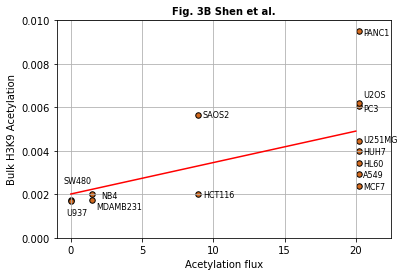

In [9]:
#Codigo para el figura 
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

x=valores_lineacelular
y=acetlevel[0,:]


plt.scatter(x,y,color="chocolate",edgecolors='black',s=30)
plt.title('Fig. 3B Shen et al.',fontsize = 10,fontweight = "bold")
plt.xlabel('Acetylation flux')
plt.ylabel('Bulk H3K9 Acetylation')

m=np.array([np.ones(14),x]).T 
#print(x,y)
plt.xlim(-1,22.5)  # Definimos el rango de valores para el eje X
plt.ylim(0,0.01) # Definimos el rango de valores para el eje y
B=np.linalg.inv(m.T @m) @ m.T @y #ec. beta para realizar la linea de tendencia


#for nombre in nombre_lineacelular:
    #print(nombre)

plt.text(x[0]+0.32,y[0]-0.00015,nombre_lineacelular[0],fontsize = 8) #A549
plt.text(x[1]+0.32,y[1]-0.00015,nombre_lineacelular[1],fontsize = 8) #HTT116
plt.text(x[2]+0.32,y[2]-0.00015,nombre_lineacelular[2],fontsize = 8) #HL60
plt.text(x[3]+0.32,y[3]-0.00015,nombre_lineacelular[3],fontsize = 8) #HUH7
plt.text(x[4]+0.32,y[4]-0.00015,nombre_lineacelular[4],fontsize = 8) #MCF7
plt.text(x[5]+1.8,y[5]-0.0004,nombre_lineacelular[5],fontsize = 8) #MDAMB231
plt.text(x[6]+0.7,y[6]-0.00020,nombre_lineacelular[6],fontsize = 8) #NB4
plt.text(x[7]+0.3,y[7]-0.00020,nombre_lineacelular[7],fontsize = 8) #PANC1
plt.text(x[8]+0.3,y[8]-0.00020,nombre_lineacelular[8],fontsize = 8) #PC3
plt.text(x[9]+0.25,y[9]-0.0001,nombre_lineacelular[9],fontsize = 8) #SAOS2
plt.text(x[10]-0.5,y[10]+0.0008,nombre_lineacelular[10],fontsize = 8) #SW480
plt.text(x[11]+0.3,y[11]+0.00025,nombre_lineacelular[11],fontsize = 8) #U2OS
plt.text(x[12]+0.3,y[12]-0.00005,nombre_lineacelular[12],fontsize = 8) #U251MG
plt.text(x[13]-1.8,y[13]-0.0007,nombre_lineacelular[13],fontsize = 8) #U937

plt.plot([0,20],[B[0]+B[1]*1,B[0]+B[1]*20],c="red")

plt.grid()
plt.show()